In [2]:
# system information
import os
from glob import glob

# computing
import numpy as np
import pandas as pd
from datetime import datetime
import scipy as sp
import scipy.optimize as op

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
%matplotlib inline

# ROOT files handling
import uproot as ur

In [3]:
# define ticks
def set_ticks(ax, xMaj, yMaj):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.minorticks_on()
    ax.tick_params(which='major', width=1.0, length=8, direction='in', labelsize=14)
    ax.tick_params(which='minor', width=1.0, length=4, direction='in', labelsize=14)
    ax.yaxis.get_offset_text().set_fontsize(14)
    ax.xaxis.get_offset_text().set_fontsize(14)

def exp(t, a_m, a_p, tau_p, tau_m, b):
    exp_p = a_p * np.exp(-t/tau_p)
    exp_m = a_m * np.exp(-t/tau_m)
    return exp_p + exp_m + b 

In [4]:
a = 0.02588903364201166 
b = 0.0117937685867166

In [5]:
freq, x_val = np.loadtxt('data/spectra_recovered.txt', unpack=True)
freq, x_val = np.array(freq), np.array(x_val)

events5 = []
for i in range(0,len(freq)):
    for j in range(0,int( freq[i] )): 
        events5.append( x_val[i] )

events5 = np.array(events5)

In [6]:
a + b*2000

23.613426207075214

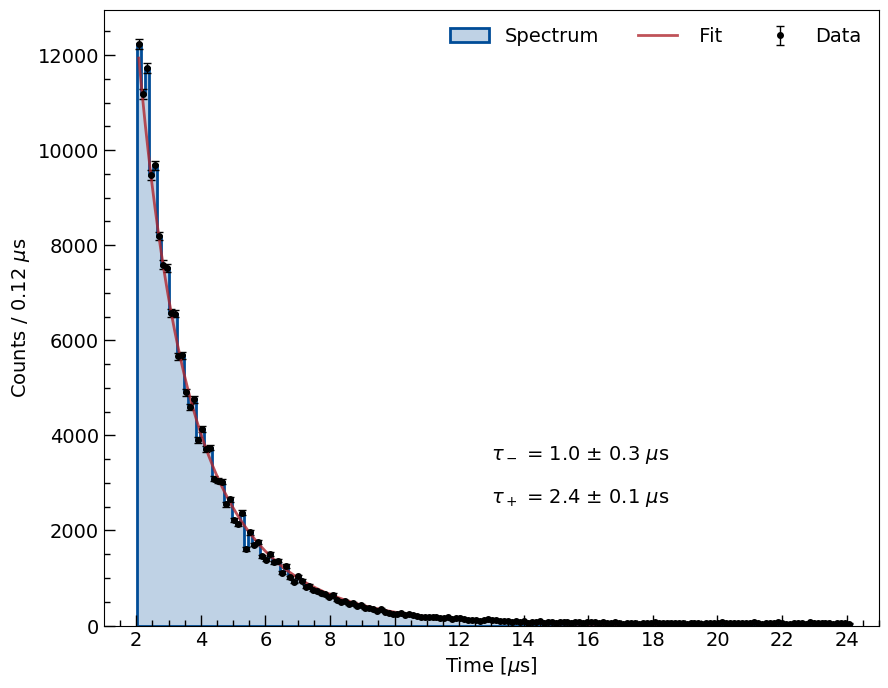

In [7]:
# access the TNtuple
events1 = ur.open("data/spectrum20220527.root:pjmca")
spectrum1 = a + b*events1['ch0'].array()

events2 = ur.open("data/spectrum20220524.root:pjmca")
spectrum2 = a + b*events2['ch0'].array()

events3 = ur.open("data/spectrum20220530.root:pjmca")
spectrum3 = a + b*events3['ch0'].array()

events4 = ur.open("data/spectrum20220601.root:pjmca")
spectrum4 = a + b*events4['ch0'].array()

events5 = ur.open("data/spectrum20220601.root:pjmca")
spectrum5 = a + b*events5['ch0'].array()

total = np.concatenate((spectrum1,spectrum2,spectrum3,spectrum4, spectrum5))
total = total[total > 2.]

# create plot
fig, ax = plt.subplots(figsize=(10,8))

nbins = 180
# plot histogram
#n, bins, _ = ax.hist(total, bins=150, fc='#004C97', alpha=0.2, label="Spectrum")
n, bins , _ = ax.hist(total, bins=nbins, histtype='stepfilled', fc='#BFD2E5', ec = '#004C97', lw=2, alpha=1, label="Spectrum")


# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  

# bin width 
binwidth = bins[1] - bins[0]

ax.errorbar(x, n, yerr=poisson_err, label='Data', marker = 'o',markerfacecolor = 'black',
                                markeredgecolor = 'black',markersize=4, lw = 0, ecolor='black', elinewidth=1, capsize=3)

# perform fit 
par, cov = op.curve_fit(f = exp, xdata = x[1:], ydata = n[1:], sigma = poisson_err[1:],
                      bounds=((2000, 30, 1.4, 0.6, 0.), (35000, 20000, 2.4, 1.,3.)) )
# get parameters
a_m, a_p, tau_p, tau_m, baseline = par
_, _, err_p, err_m,_  = np.sqrt(np.diag(cov))

# create array to plot fit results 
x_g = np.arange(x[0],20,0.02)

# plot curve and data points
ax.plot(x_g, exp(x_g, *par), color = '#AF272F', ls='-', alpha=0.8, lw=2, label = ' Fit')

# labels
ax.set_xlabel("Time [$\mu$s]", fontsize=14)
ax.set_ylabel("Counts / %1.2f $\mu$s" %binwidth, fontsize=14)

# ticks
set_ticks(ax, 2, 2000)

# limits 
ax.set_xlim(1,25)

# legend
ax.legend(loc="upper right", frameon=False, fontsize=14, ncol=3)

ax.text(0.5,0.27, '$\\tau_-$ = %1.1f $\\pm$ %1.1f $\\mu$s ' % (tau_m,err_m),fontsize = 14,  transform=ax.transAxes)
ax.text(0.5,0.2, '$\\tau_+$ = %1.1f $\\pm$ %1.1f $\\mu$s ' % (tau_p,err_p),fontsize = 14,  transform=ax.transAxes)


# show and save
#fig.savefig('spectrum_fit.pdf', dpi = 200)
plt.show()

In [148]:
x[80]

1.8998000621795654

In [12]:
total_events = len(total)
total_time = (194.*3600 + 56.*60 + 115.*3600 + 51.*60) 
rate = total_events/total_time
print(total_time/3600,rate)

310.78333333333336 0.17379471228615864


## Second approach

In [195]:
def exponential(x, a, tau):
    return a * np.exp(- x / tau)

[2.69115476e+04 2.06210847e+00]


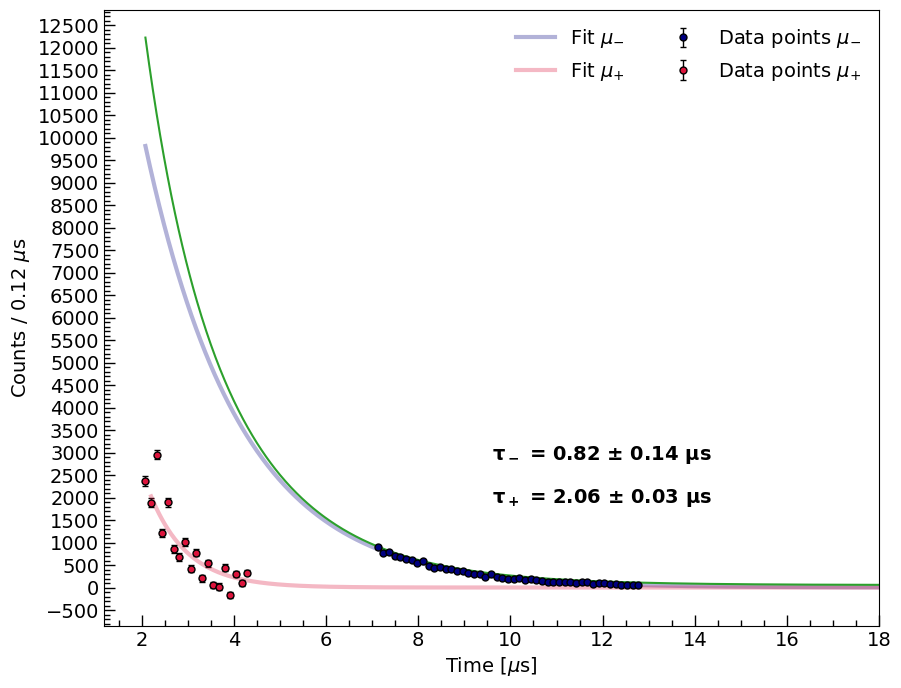

[3.00000000e+04 8.17525164e-01]


In [201]:
# create plot
fig, ax = plt.subplots(figsize=(10,8))

# extract the baseline from 7 * tau_2
indeces = np.where(x > 15.)
i = indeces[0][0]
baseline = np.mean(n[int(i):])

# select between 7 us and 11 us
indeces = np.where(x > 7)
i_in = indeces[0][0]
indeces = np.where(x < 13.)
i_fin = indeces[0][-1]

# subtract the baseline
n_p = n[i_in:i_fin] - baseline

# compute fit
par, cov = op.curve_fit(f = exponential, xdata = x[i_in:i_fin], ydata = n_p, sigma = poisson_err[i_in:i_fin])

print(par)
# plot
ax.errorbar(x[i_in:i_fin], n_p, yerr=poisson_err[i_in:i_fin], label='Data points $\mu_{-}$', marker = 'o',markerfacecolor = 'navy',
                                markeredgecolor = 'black',markersize=5, lw = 0, ecolor='black', elinewidth=1, capsize=2)
x_g = np.arange(x[0],20,0.02)
ax.plot(x_g, exponential(x_g, *par), color = 'navy', ls='-', alpha=0.3, lw=3, label = 'Fit $\mu_{-}$')

# get parameters
a_p, tau_p = par
s_a_p, s_tau_p  = np.sqrt(np.diag(cov))

# fit between 3 us and 6 us
indeces = np.where(x > 2.06)
i_in = indeces[0][0]
indeces = np.where(x < 4.5)
i_fin = indeces[0][-1]

# subtract the baseline
# n_n = n[i_in:i_fin] - baseline - exponential(9., *par) * np.exp((x[i_in:i_fin] - 9.)/tau_p)
n_n = n[i_in:i_fin] - baseline - exponential(x[i_in:i_fin], *par)

# compute fit
par, cov = op.curve_fit(f = exponential, xdata = x[i_in:i_fin], ydata = n_n, sigma = poisson_err[i_in:i_fin], bounds =((1e3,0.7),(3e4,1.5)))

# plot
ax.errorbar(x[i_in:i_fin], n_n, yerr=poisson_err[i_in:i_fin], label='Data points $\mu_{+}$', marker = 'o',markerfacecolor = 'crimson',
                                markeredgecolor = 'black',markersize=5, lw = 0, ecolor='black', elinewidth=1, capsize=2)
x_g = np.arange(x[1],20,0.02)
ax.plot(x_g, exponential(x_g, *par), color = 'crimson', ls='-', alpha=0.3, lw=3, label = 'Fit $\mu_{+}$')

# get parameters
a_n, tau_n = par
s_a_n, s_tau_n  = np.sqrt(np.diag(cov))

# print
ax.text(0.5,0.27, '$\\mathbf{\\tau_-}$ = %1.2f $\\mathbf{\\pm}$ %1.2f $\\mathbf{\\mu}$s ' % (tau_n, s_tau_n), 
        fontweight = 'bold',fontsize = 14,  transform=ax.transAxes)
ax.text(0.5,0.2, '$\\mathbf{\\tau_+}$ = %1.2f $\\mathbf{\\pm}$ %1.2f $\\mathbf{\\mu}$s ' % (tau_p, s_tau_p), 
        fontweight = 'bold',fontsize = 14,  transform=ax.transAxes)

# labels
ax.set_xlabel("Time [$\mu$s]", fontsize=14)
ax.set_ylabel("Counts / %1.2f $\mu$s" %binwidth, fontsize=14)

# ticks
set_ticks(ax, 2, 500)

# limits 
ax.set_xlim(right= 18)

# legend
ax.legend(loc="upper right", frameon=False, fontsize=14, ncol=2)

x_g = np.arange(x[0],20,0.02)

y = exp(x_g, a_n, a_p, tau_p, tau_n, baseline )

ax.plot(x_g,y)
#ax.errorbar(x, n, yerr=poisson_err, label='Data', marker = 'o',markerfacecolor = 'black',
      #                          markeredgecolor = 'black',markersize=4, lw = 0, ecolor='black', elinewidth=1, capsize=3)



#fig.savefig('spectrum_fit2.pdf',dpi=200)
plt.show()
print(par)


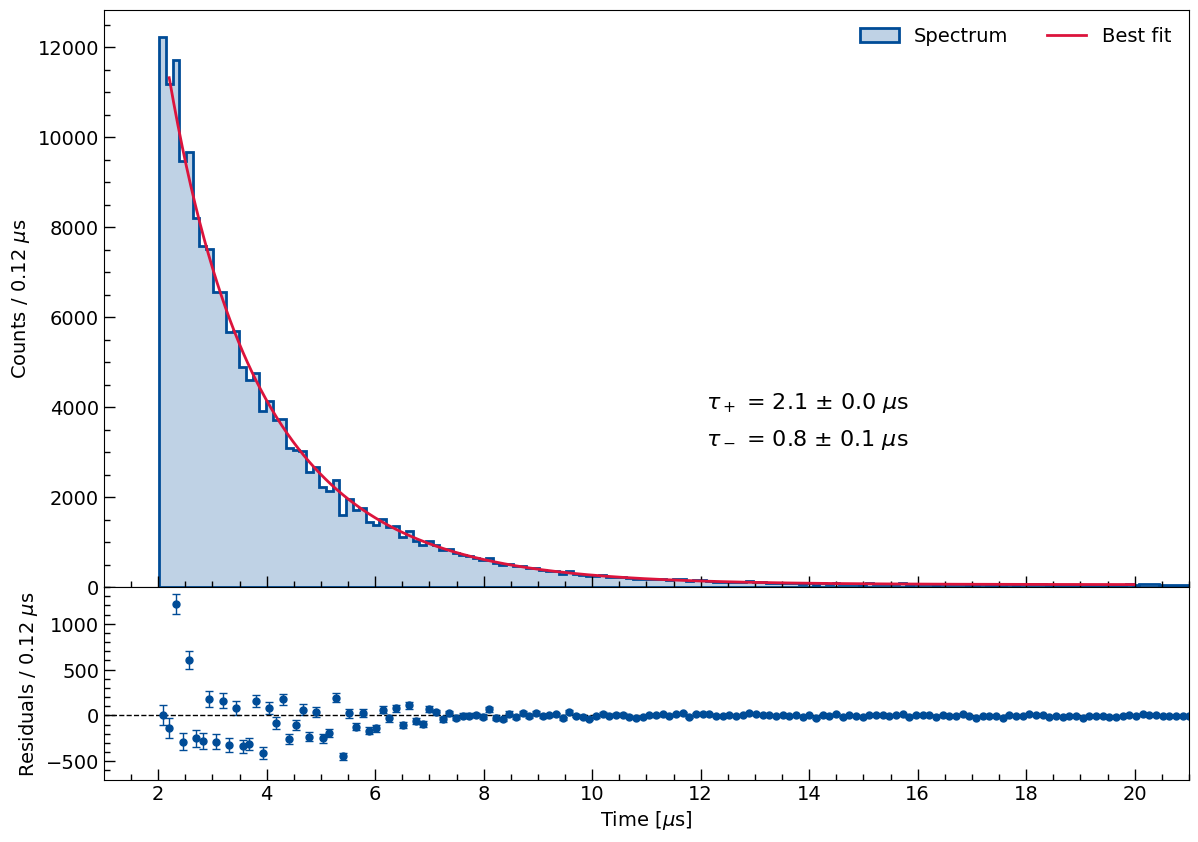

In [202]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharex = ax1)

y, bins , _ = ax1.hist(total, bins=180, histtype='stepfilled',fc='#BFD2E5', ec = '#004C97', lw=2, alpha=1, label="Spectrum")

# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  

# bin width 
binwidth = bins[1] - bins[0]

#ax1.errorbar(x, n, yerr=poisson_err, label='Data', marker = 'o',markerfacecolor = 'black',
#                               markeredgecolor = 'black',markersize=4, lw = 0, ecolor='black', elinewidth=1, capsize=3)

x_g = np.arange(x[1],20,0.02)

y_th = exp(x_g, a_n, a_p, tau_p, tau_n, baseline)
y_res = exp(x, a_n, a_p, tau_p, tau_n, baseline)
res = y - y_res 

rel_err = 100 * (res / y_res)


ax1.plot(x_g,y_th, color = 'crimson', ls='-', alpha=1, lw=2, label = 'Best fit')

ax2.errorbar(x, res,yerr=poisson_err, marker='o', markersize=5, 
                color='#004C97', linestyle='none', ecolor='#004C97', elinewidth=1, capsize=3)

ax2.axhline(color = 'black', linewidth = 1, linestyle = '--')

# labels
ax2.set_xlabel("Time [$\mu$s]", fontsize=14)
ax1.set_ylabel("Counts / %1.2f $\mu$s" %binwidth, fontsize=14)
ax2.set_ylabel("Residuals / %1.2f $\mu$s" %binwidth, fontsize=14)

# ticks
set_ticks(ax1, 2, 2000)
set_ticks(ax2, 2, 500)
# limits 
ax1.set_xlim(left = 1, right= 21)
ax2.set_ylim(-700,1400)
# legend
ax1.legend(loc="upper right", frameon=False, fontsize=14, ncol=2)

fig.subplots_adjust(hspace=0)

ax1.text(0.75,0.5, '$\\tau_-$ = %1.1f $\\pm$ %1.1f $\\mu$s ' % (tau_n,s_tau_n),fontsize = 16,  transform=ax.transAxes)
ax1.text(0.75,0.56, '$\\tau_+$ = %1.1f $\\pm$ %1.1f $\\mu$s ' % (tau_p,s_tau_p),fontsize = 16,  transform=ax.transAxes)


#fig.savefig('totalfit_rebin.pdf',dpi=200)

plt.show()

In [33]:
def exp(t, a_m, a_p, tau_p, tau_m, b):
    exp_p = a_p * np.exp(-t/tau_p)
    exp_m = a_m * np.exp(-t/tau_m)
    return exp_p + exp_m + b 

x_g = np.arange(x[0],20,0.02)

y = exp(x_g, a_n, a_p, tau_p, tau_n, baseline )

In [11]:
freq, x_val = np.loadtxt('data/spectra_recovered.txt', unpack=True)
freq, x_val = np.array(freq), np.array(x_val)

In [12]:
data = np.loadtxt('data/spectra_recovered.txt')

In [13]:
data = np.array(data)

In [14]:
spectrum = []
for i in range(0,len(data)):
    for j in range(0,int( data[i][0] )): 
        spectrum.append( data[i][1] )

In [50]:
spectrum = []
for i in range(0,len(freq)):
    for j in range(0,int( freq[i] )): 
        spectrum.append( x_val[i] )

## Analysis of raw spectrum


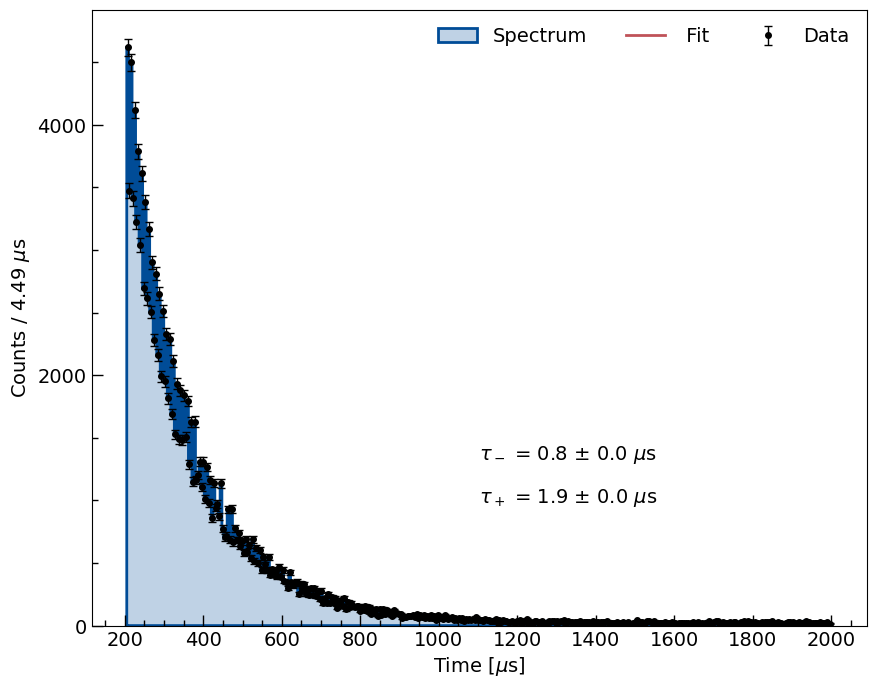

In [176]:
# access the TNtuple
events1 = ur.open("data/spectrum20220527.root:pjmca")
spectrum1 = events1['ch0'].array()

events2 = ur.open("data/spectrum20220524.root:pjmca")
spectrum2 = events2['ch0'].array()

events3 = ur.open("data/spectrum20220530.root:pjmca")
spectrum3 = events3['ch0'].array()

events4 = ur.open("data/spectrum20220601.root:pjmca")
spectrum4 = events4['ch0'].array()

events5 = ur.open("data/spectrum20220601.root:pjmca")
spectrum5 = events5['ch0'].array()

total = np.concatenate((spectrum1,spectrum2,spectrum3,spectrum4, spectrum5))
total = total[total > 2.]

# create plot
fig, ax = plt.subplots(figsize=(10,8))

nbins = 400
# plot histogram
#n, bins, _ = ax.hist(total, bins=150, fc='#004C97', alpha=0.2, label="Spectrum")
n, bins , _ = ax.hist(total, bins=nbins, range = [205,2000], histtype='stepfilled',fc='#BFD2E5', ec = '#004C97', lw=2, alpha=1, label="Spectrum")


# array of bin centers
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins) - 1)])

# set Poisson uncertainty on each bin   
poisson_err =  np.sqrt(n)  

# bin width 
binwidth = bins[1] - bins[0]

ax.errorbar(x, n, yerr=poisson_err,label='Data', marker = 'o',markerfacecolor = 'black',
                              markeredgecolor = 'black',markersize=4, lw = 0, ecolor='black', elinewidth=1, capsize=3)

# perform fit 
par, cov = op.curve_fit(f = exp, xdata = x[1:], ydata = n[1:], sigma = poisson_err[1:],
                      bounds=((2000, 30, 1.4, 0.6, 0.), (35000, 20000, 2.4, 1.,3.)) )
# get parameters
a_m, a_p, tau_p, tau_m, baseline = par
_, _, err_p, err_m,_  = np.sqrt(np.diag(cov))

# create array to plot fit results 
x_g = np.arange(x[1],20,0.02)

# plot curve and data points
ax.plot(x_g, exp(x_g, *par), color = '#AF272F', ls='-', alpha=0.8, lw=2, label = ' Fit')

# labels
ax.set_xlabel("Time [$\mu$s]", fontsize=14)
ax.set_ylabel("Counts / %1.2f $\mu$s" %binwidth, fontsize=14)

# ticks
set_ticks(ax, 200, 2000)

# limits 
#ax.set_xlim(1,2000)

# legend
ax.legend(loc="upper right", frameon=False, fontsize=14, ncol=3)

ax.text(0.5,0.27, '$\\tau_-$ = %1.1f $\\pm$ %1.1f $\\mu$s ' % (tau_m,err_m),fontsize = 14,  transform=ax.transAxes)
ax.text(0.5,0.2, '$\\tau_+$ = %1.1f $\\pm$ %1.1f $\\mu$s ' % (tau_p,err_p),fontsize = 14,  transform=ax.transAxes)


# show and save
#fig.savefig('spectrum_fit.pdf', dpi = 200)
plt.show()